# Donnée Static Grid Model

1. Accès au dataset des lignes françaises du GRT RTE en date de 2019. Données en accès : I_max saisonniers, stations, longueurs, caractéristiques
Source : https://www.services-rte.com/en/learn-more-about-our-services/static-grid-model.html
Problèmes éventuels : données lacunaire et datées (2019)

2. Dataset : [Lignes aériennes RTE – nouveau découpage (au 10 juin 2024)](https://odre.opendatasoft.com/explore/dataset/lignes-aeriennes-rte-nv/information/?disjunctive.etat&disjunctive.tension&dataChart=eyJxdWVyaWVzIjpbeyJjaGFydHMiOlt7InR5cGUiOiJjb2x1bW4iLCJmdW5jIjoiQ09VTlQiLCJ5QXhpcyI6ImxvbmdpdHVkZV9kZWJ1dF9zZWdtZW50Iiwic2NpZW50aWZpY0Rpc3BsYXkiOnRydWUsImNvbG9yIjoicmFuZ2UtQWNjZW50In1dLCJ4QXhpcyI6InRlbnNpb24iLCJtYXhwb2ludHMiOm51bGwsInNvcnQiOiIiLCJzZXJpZXNCcmVha2Rvd24iOiJldGF0Iiwic2VyaWVzQnJlYWtkb3duVGltZXNjYWxlIjoiIiwiY29uZmlnIjp7ImRhdGFzZXQiOiJsaWduZXMtYWVyaWVubmVzLXJ0ZS1udiIsIm9wdGlvbnMiOnsiZGlzanVuY3RpdmUuZXRhdCI6dHJ1ZSwiZGlzanVuY3RpdmUudGVuc2lvbiI6dHJ1ZX19fV0sInRpbWVzY2FsZSI6IiIsImRpc3BsYXlMZWdlbmQiOnRydWUsImFsaWduTW9udGgiOnRydWV9&location=13,45.56282,4.83351&basemap=jawg.light) / 

## Importations de librairie

In [311]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import json 
import seaborn as sns

import plotly.express as px
import plotly.graph_objects as go

from sklearn.cluster import DBSCAN
from sklearn.linear_model import LinearRegression

### Fonctions

In [312]:
def scatter_plot(df, colors, X_name, Y_name):

    # Create the plot
    plt.figure(figsize=(12, 8))

    for voltage_level in df['Voltage level (kV)'].unique():
        
        # subset is over different voltage  and exclude short lines
        subset_0 = df[(df['Voltage level (kV)'] == voltage_level)]
        subset = subset_0[subset_0['Length (m)'] > subset_0['Length (m)'].quantile(0.05)]
        
        plt.scatter(subset[X_name], subset[Y_name], 
                    color=colors[str(voltage_level)], 
                    label=f'Voltage Level: {voltage_level}', 
                    s=50, alpha=0.7)

    # Customize the plot
    plt.title(f'{X_name} vs {Y_name}', fontsize=16)
    plt.xlabel(X_name, fontsize=12)
    plt.ylabel(Y_name, fontsize=12)
    plt.xticks(rotation=90, ha='right')

    # Add legend without a color bar
    plt.legend(title='Voltage Levels')
    plt.tight_layout()

    # Display the plot
    plt.show()
    
def hist_plot_1(df, list_col):
    col_name = list_col[0]
    col_name_title = list_col[1]
    # Create the plot
    for voltage_level in df['Voltage level (kV)'].unique():
    
        # subset is over different voltage  and exclude short lines
        subset_0 = df[(df['Voltage level (kV)'] == voltage_level)].copy()
        subset = subset_0[subset_0['Length (m)'] > subset_0['Length (m)'].quantile(0.05)].copy()
        subset.reset_index(drop=True, inplace=True)
        subset[col_name_title] = subset[col_name] / subset['Length (m)'] * 1000
        
        plt.figure(figsize=(12, 8))
        ax = sns.histplot(data = subset, x = col_name_title, kde = True, bins=200)
        
        # Get the histogram data
        hist_data = ax.patches
        
        # Find the bin with the highest count
        max_count_patch = max(hist_data, key=lambda p: p.get_height())
        max_count = max_count_patch.get_height()
        max_count_bin = max_count_patch.get_x() + max_count_patch.get_width() / 2

        # Add a vertical line at the most frequent value
        plt.axvline(max_count_bin, color='red', linestyle='dashed', linewidth=2)
        
        # Add text annotation
        plt.text(max_count_bin, max_count, f'Most frequent: {max_count_bin:.3f}', 
            horizontalalignment='right', verticalalignment='bottom')

        # Customize the plot
        plt.title(f'Histplot {col_name} / length for voltage {voltage_level} kV', fontsize=16)
        plt.xlabel(col_name_title, fontsize=12)
        plt.ylabel('Occurence', fontsize=12)
        plt.xticks(rotation=30, ha='right')
        plt.tight_layout()

        # Display the plot
        plt.show()
        
def hist_plot_2(df, Y_name):
    
    for voltage_level in df['Voltage level (kV)'].unique():
        
        # subset is over different voltage  and exclude short lines
        subset_0 = df[(df['Voltage level (kV)'] == voltage_level)].copy()
        subset = subset_0[subset_0['Length (m)'] > subset_0['Length (m)'].quantile(0.05)].copy()
        subset.reset_index(drop=True, inplace=True)

        
        plt.figure(figsize=(12, 8))
        ax = sns.histplot(data = subset, x = Y_name, kde = True, bins=100)
        
        # Get the histogram data
        hist_data = ax.patches
        
        # Find the bin with the highest count
        max_count_patch = max(hist_data, key=lambda p: p.get_height())
        max_count = max_count_patch.get_height()
        max_count_bin = max_count_patch.get_x() + max_count_patch.get_width() / 2

        # Add a vertical line at the most frequent value
        plt.axvline(max_count_bin, color='red', linestyle='dashed', linewidth=2)
        
        # Add text annotation
        plt.text(max_count_bin, max_count, f'Most frequent: {max_count_bin:.3f}', 
            horizontalalignment='right', verticalalignment='bottom')

        # Customize the plot
        plt.title(f'Histplot {Y_name} for voltage {voltage_level} kV', fontsize=16)
        plt.xlabel(Y_name, fontsize=12)
        plt.ylabel('Occurence', fontsize=12)
        plt.xticks(rotation=30, ha='right')
        plt.tight_layout()

        # Display the plot
        plt.show()

## DATA Lignes

### Ligne 2019 + caractéristiques : THT

In [313]:
path = '/Users/matthiasmolenat/repos/congestion/data/RT_ligne_2019.csv'
df_ligne_RT_2019 = pd.read_csv(path,delimiter=';',index_col=0, decimal=',')
df_ligne_RT_2019['P_max_summer (MW)']=df_ligne_RT_2019['Voltage level (kV)']*df_ligne_RT_2019['I_max_Summer']/1000
df_ligne_RT_2019.head()

,Circuit name,sub_1_short,sub_2_short,Voltage level (kV),I_max_Summer,I_max_Interseason_1,I_max_Interseason_2,I_max_Winter,Resistance R (Ω),Reactance X (Ω),Capacity (nF),Half-Susceptance Hd/2 (μS),Length (m),Unnamed: 14,P_max_summer (MW)
ref,,,,,,,,,,,,,,,
AIRVAL61BONN6,LIT 225kV N0 1 AIRVAULT-BONNEAU,AIRVA,BONN6,225,932.0,932.0,1145.0,1145.0,3.064,20.350,762.736,119.810,52792,NaN,209.700
AIRVAL61JUMEA,LIT 225kV N0 1 AIRVAULT-JUMEAUX (LES),AIRVA,JUMEA,225,1249.0,1337.0,1337.0,1434.0,0.330,2.212,50.501,7.933,5507,NaN,281.025
ALBERL61CHAV6,LIT 225kV N0 1 ALBERTVILLE-CHAVANOD,ALBER,CHAV6,225,617.0,685.0,685.0,742.0,4.460,17.210,17.210,60.000,42135,NaN,138.825
ALBERL61CONTA,LIT 225kV N0 1 ALBERTVILLE-CONTAMINE,ALBER,CONTA,225,565.0,673.0,673.0,765.0,2.352,10.043,225.097,35.358,24925,NaN,127.125
ALBERL61LONG6,LIT 225kV N0 1 ALBERTVILLE-LONGEFAN,ALBER,LONG6,225,565.0,673.0,673.0,765.0,4.486,17.749,391.180,61.446,43669,NaN,127.125


In [314]:
print(df_ligne_RT_2019.shape)
print(df_ligne_RT_2019.columns)

(921, 15)
Index(['Circuit name', 'sub_1_short', 'sub_2_short', 'Voltage level (kV)',
       'I_max_Summer', 'I_max_Interseason_1', 'I_max_Interseason_2',
       'I_max_Winter', 'Resistance R (Ω)', 'Reactance X (Ω)', 'Capacity (nF)',
       'Half-Susceptance Hd/2 (μS)', 'Length (m)', 'Unnamed: 14',
       'P_max_summer (MW)'],
      dtype='object')


#### Récupération de donnée types :

On cherche à obtenir des grandeurs type de caractéristiques physiques pour compléter des données lacunaires. 

Hypothèse : Pour un type de ligne donné (voltage level), les grandeurs :
- $\frac{resistance}{longueur}$,
- $\frac{reactance}{longueur}$,

se conserve. 

Une étude supplémentaire doit être mené pour la valeur de $I_{max}$

##### Résistances & réactances

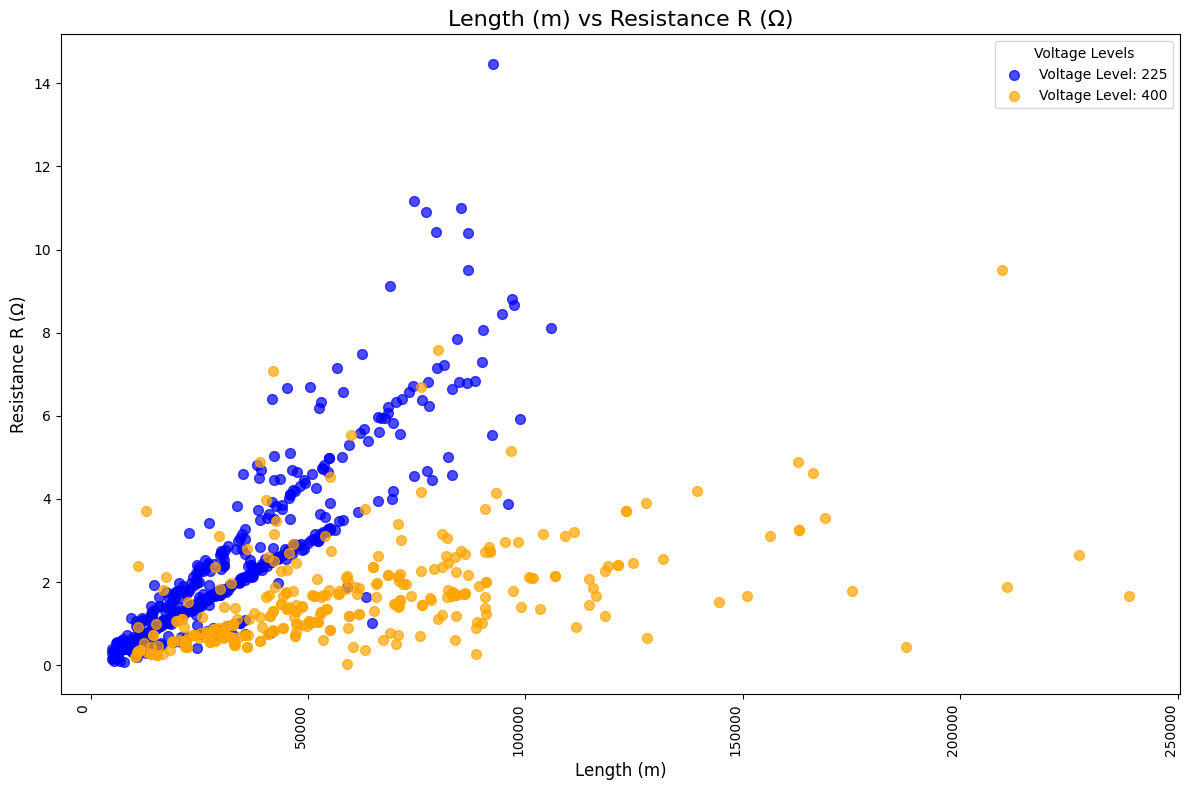

In [315]:
# Define colors for the two voltage levels
colors = {'225': 'blue', '400': 'orange'} 
X_name = 'Length (m)'
Y_name = 'Resistance R (Ω)'
scatter_plot(df_ligne_RT_2019, colors, X_name, Y_name)

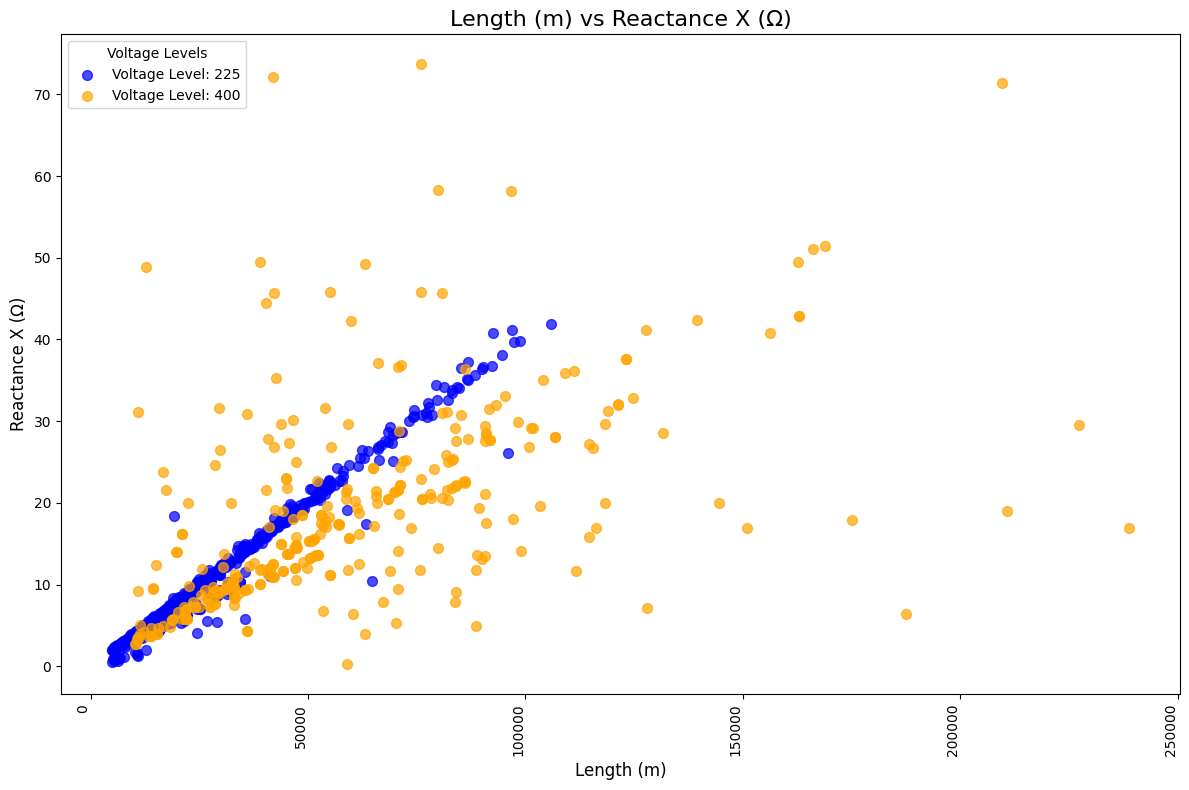

In [316]:
# Define colors for the two voltage levels
colors = {'225': 'blue', '400': 'orange'} 
X_name = 'Length (m)'
Y_name = 'Reactance X (Ω)'
scatter_plot(df_ligne_RT_2019, colors, X_name, Y_name)

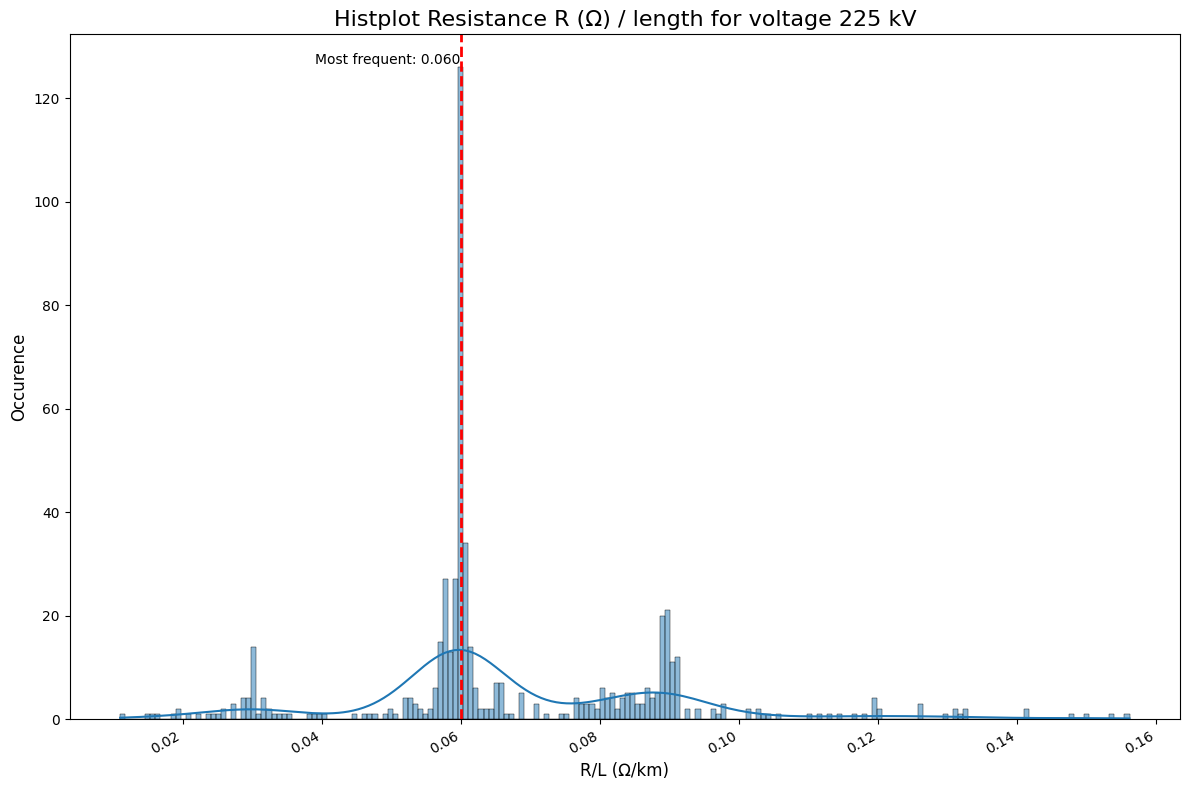

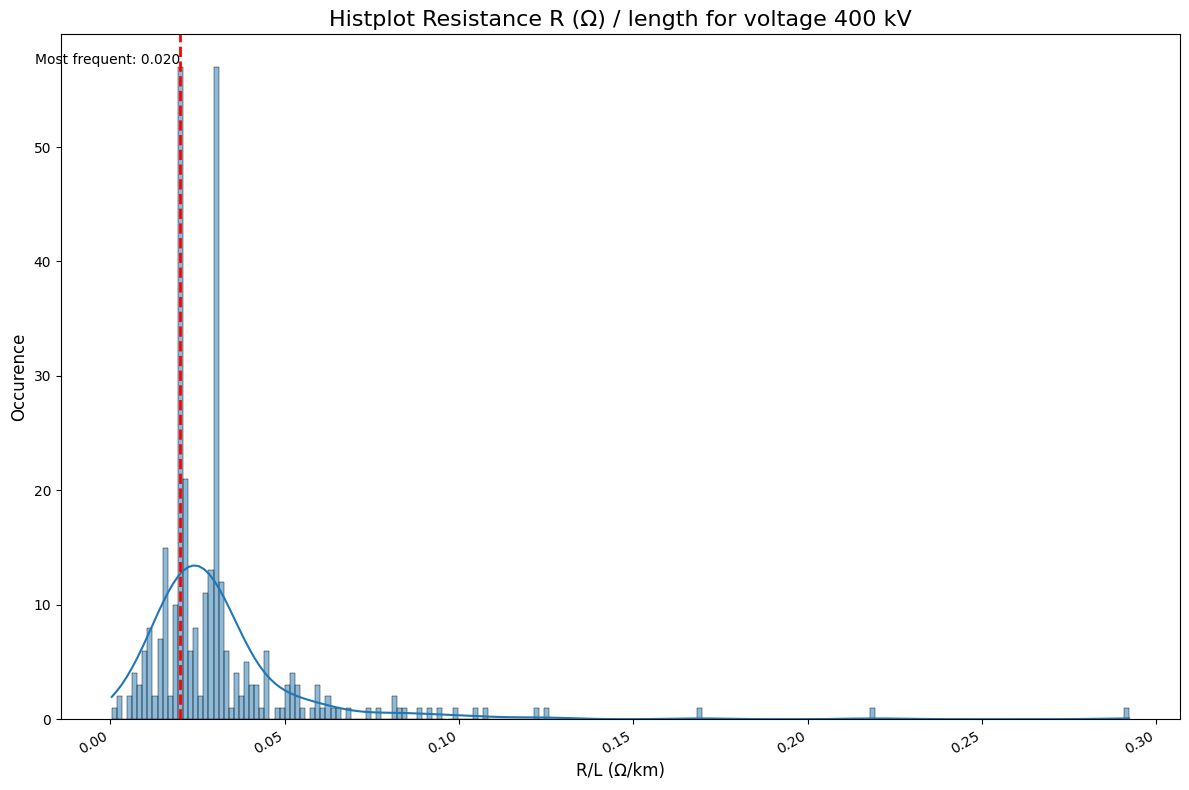

In [317]:
list_col =  ['Resistance R (Ω)', 'R/L (Ω/km)' ]
hist_plot_1(df_ligne_RT_2019, list_col)

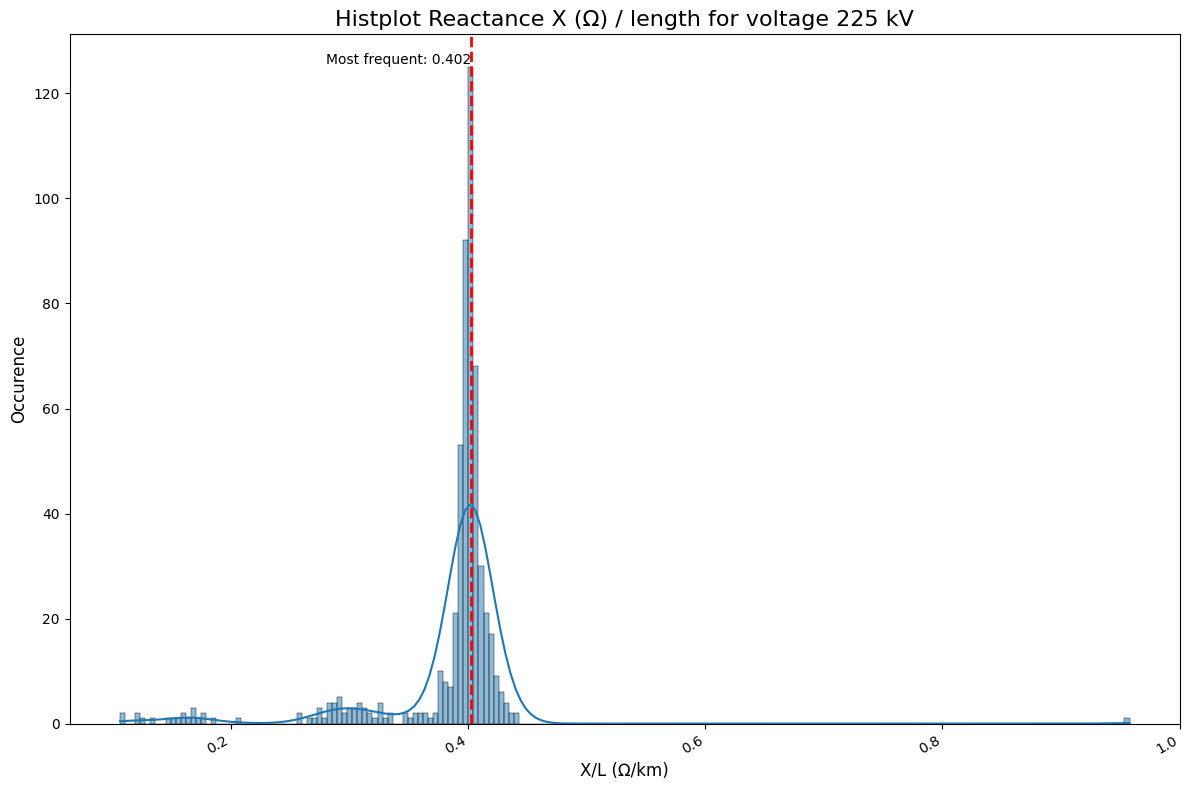

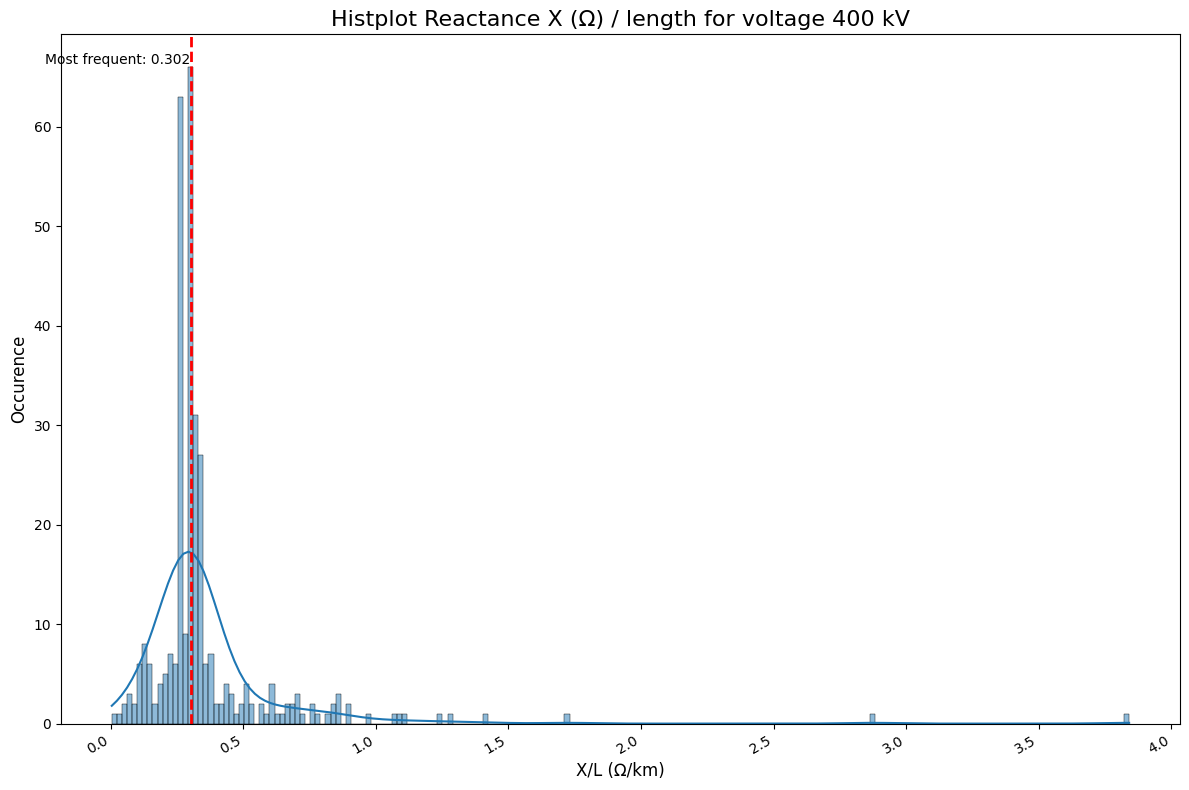

In [318]:
list_col =  ['Reactance X (Ω)', 'X/L (Ω/km)' ]
hist_plot_1(df_ligne_RT_2019, list_col)

##### Courant max :

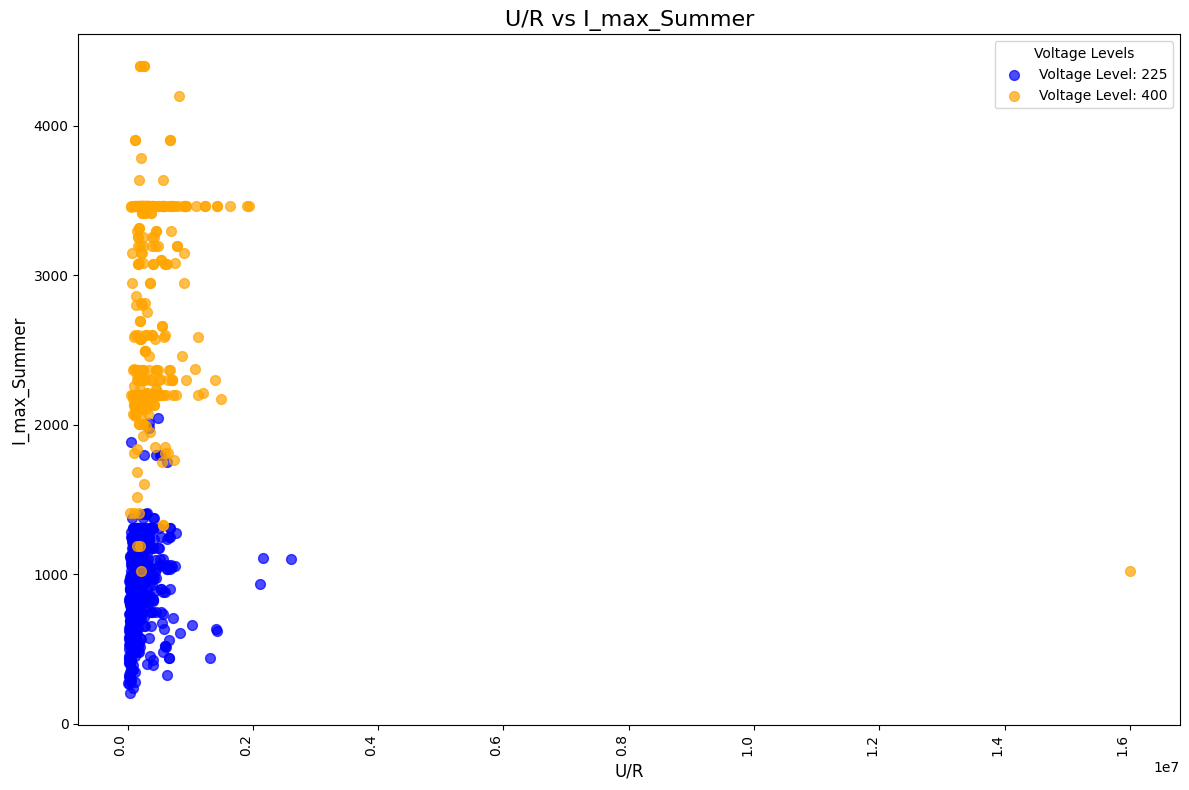

In [319]:
df_ligne_RT_2019['U/R'] = df_ligne_RT_2019['Voltage level (kV)']*1000/df_ligne_RT_2019['Resistance R (Ω)']

# Define colors for the two voltage levels
colors = {'225': 'blue', '400': 'orange'} 
X_name = 'U/R'
Y_name = 'I_max_Summer'
scatter_plot(df_ligne_RT_2019, colors, X_name, Y_name)

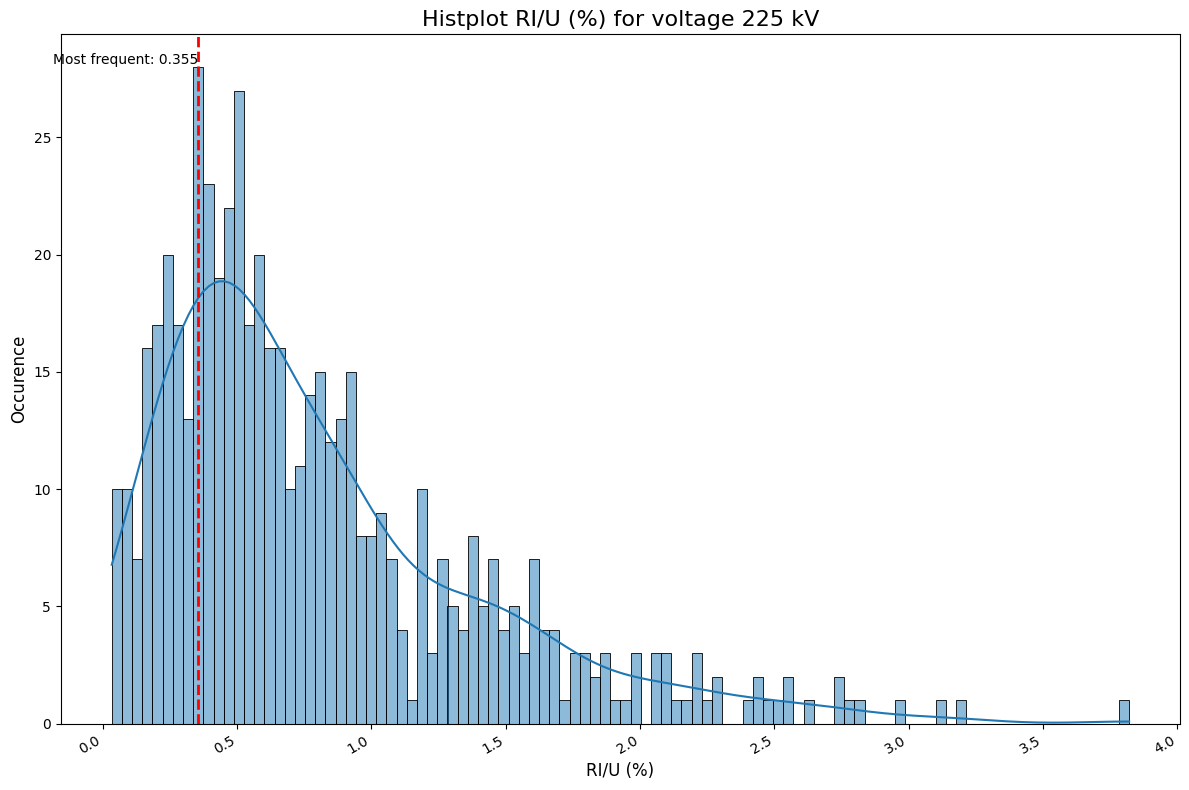

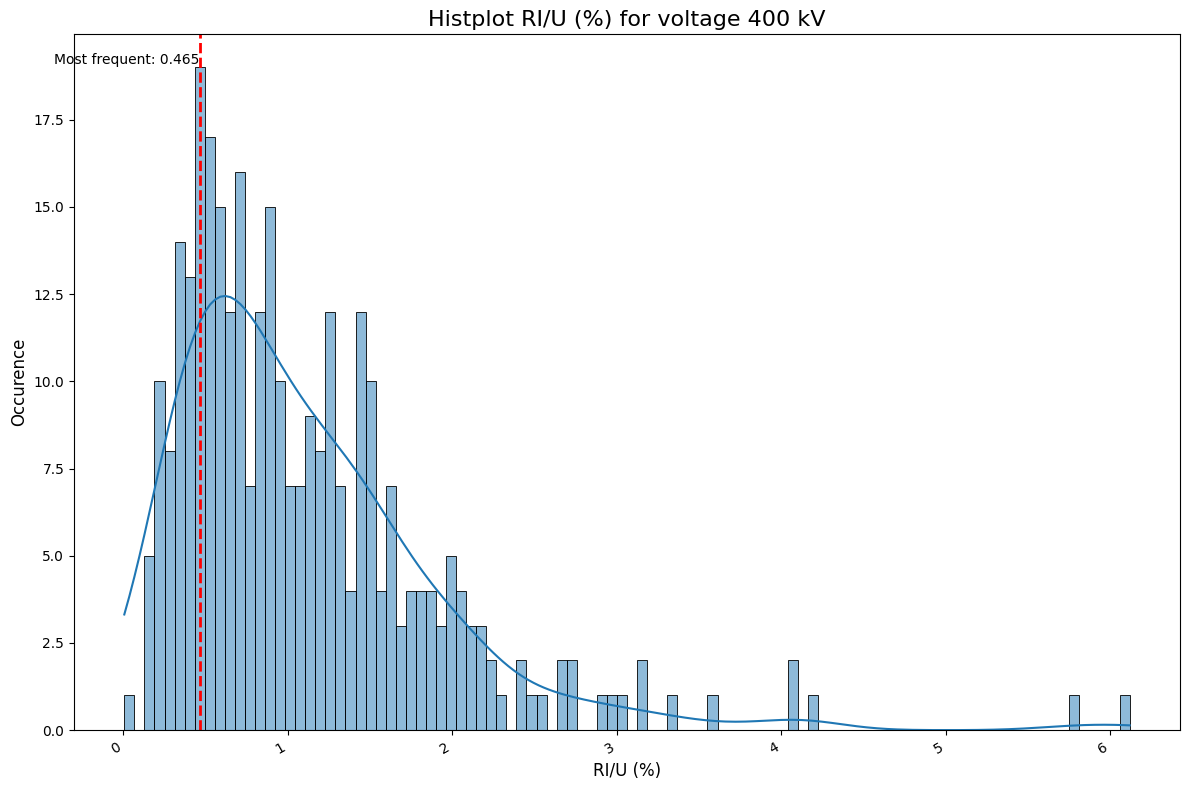

In [320]:
Y_name = 'RI/U (%)' # Pertes / Puissance transitée
df_ligne_RT_2019['RI/U (%)'] = df_ligne_RT_2019['Resistance R (Ω)']*df_ligne_RT_2019['I_max_Summer']/df_ligne_RT_2019['Voltage level (kV)']/10
hist_plot_2(df_ligne_RT_2019, Y_name)

##### Résultats :

En tant que premières bonnes approximations, on prends :

In [321]:
R_per_km_225 = 0.06 # Ohm / km
X_per_km_225 = 0.402 # Ohm / km

R_per_km_400 = 0.02 # Ohm / km
X_per_km_400 = 0.302 # Ohm / km

pertes_225 = 0.355 # %
pertes_400 = 0.465 # %


##### Commentaires : 

1. Pour la modélisation des lignes, on observe dans certains cas deux types distincts et de poids équivalent. Plusieurs choix possibles : moyenne, définitions de deux modèles, etc.
2. On retrouve les chiffres R/L et X/L avancés dans https://www.techno-science.net/definition/6745.html
3. intensité max : on suppose un ratio de perte autorisé max sur la ligne. $ratio = \frac{Pertes = RI^2}{Transmis = UI}$. A Approfondir? 

#### Chercher toutes les lignes associées à un poste

In [322]:
name_str = 'ECHALAS'

df_ligne_RT_poste = df_ligne_RT_2019[df_ligne_RT_2019.apply(lambda row: row.astype(str).str.contains(name_str).any(), axis=1)]


### Lignes 2024 

In [323]:
path_ligne_aer = '/Users/matthiasmolenat/repos/congestion/data/lignes-aeriennes-rte-nv.csv'
df_ligne_RT_2023 = pd.read_csv(path_ligne_aer,delimiter=';')
df_ligne_RT_2023.head()

,Type ouvrage,Code ligne 1,Nom ligne 1,Propriétaire ligne 1,Etat,TENSION,Source donnée,Geo Shape,Nombre circuit,Code ligne 2,...,Code ligne 3,Nom ligne 3,Propriétaire ligne 3,Code ligne 4,Nom ligne 4,Propriétaire ligne 4,Code ligne 5,Nom ligne 5,Proprietaire ligne 5,geo_point_2d
0,AERIEN,ROLAML61ZRIGO,LIAISON 225kV N0 1 PUSY - RIGOTTE (LA) - ROLAM...,MAINTENU PAR ET PROPRIETE RTE,EN EXPLOITATION,225kV,RTE,"{""coordinates"": [[5.7085749089, 47.7587819641]...",1,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"47.82855513836, 5.491070148827368"
1,AERIEN,CEBAZL31RIOM,LIAISON 63kV N0 1 CEBAZAT-RIOM,MAINTENU PAR ET PROPRIETE RTE,EN EXPLOITATION,63kV,RTE,"{""coordinates"": [[3.1228486356, 45.8837232437]...",1,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"45.883755153600006, 3.12276277745"
2,AERIEN,CROIXL62P.ME5,LIAISON 225kV N0 2 CROIX (LA) - PETIT-MENIN,MAINTENU PAR ET PROPRIETE RTE,EN EXPLOITATION,225kV,RTE,"{""coordinates"": [[3.1302285506, 50.7103537288]...",1,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"50.71040177335, 3.1305627690499995"
3,AERIEN,COULAL71TAVEL,LIAISON 400kV N0 1 COULANGE - TAVEL,MAINTENU PAR ET PROPRIETE RTE,EN EXPLOITATION,400kV,RTE,"{""coordinates"": [[4.7217727214, 44.6325603872]...",1,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"44.632447227149996, 4.72240015955"
4,AERIEN,ARGE8L41GACE,LIAISON 90kV N0 1 ARGENTAN-GACE,MAINTENU PAR ET PROPRIETE RTE,EN EXPLOITATION,90kV,RTE,"{""coordinates"": [[-0.0089275157, 48.7425637902...",2,ARGE8L41VASTO,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"48.77603848796921, 0.01729029857262007"


In [324]:
for i in range(10):
    print(df_ligne_RT_2023['Geo Shape'].iloc[i])

{"coordinates": [[5.7085749089, 47.7587819641], [5.7052874722, 47.7597415148], [5.7020076415, 47.7606943545], [5.698757684, 47.7616357054], [5.6953049994, 47.7626365488], [5.6918384105, 47.7636537986], [5.6885975102, 47.7645936958], [5.6854608366, 47.7655113296], [5.6821507922, 47.766463379], [5.6788886524, 47.7674125155], [5.6757950979, 47.7683181097], [5.6726081466, 47.7692518574], [5.6694206248, 47.7701782383], [5.6662386861, 47.7710846561], [5.6629626419, 47.7720336368], [5.6595318128, 47.7730436453], [5.6571071307, 47.773739896], [5.6540862737, 47.774640569], [5.6512171272, 47.7755088506], [5.6485998803, 47.7763109406], [5.6455207428, 47.7772279806], [5.642128742, 47.7782519257], [5.6387997672, 47.77925634], [5.6354268589, 47.7802670284], [5.6321643654, 47.7812427192], [5.6287007417, 47.7822868256], [5.6253284113, 47.7832890925], [5.6219103506, 47.7843139691], [5.6187940086, 47.7852526569], [5.6154170236, 47.7862502552], [5.6119152251, 47.7872919455], [5.6084198118, 47.7883288459]

In [325]:
df_ligne_RT_2023.shape

(13210, 22)

### Extrapolation caractéristiques éléctrotechniques 2024 depuis les lignes 2019

## DATA Postes 

1.

## DATA Contraintes 

1. [Contraintes résiduelles prospectives sur le RPT à horizon 3 à 5 ans (à février 2024)](https://odre.opendatasoft.com/explore/dataset/contraintes-region/export/?location=7,46.18744,3.57056&basemap=jawg.light)

In [326]:
path = '/Users/matthiasmolenat/repos/congestion/data/contraintes-region.csv'
df_contraintes_sites = pd.read_csv(path,delimiter=';',index_col=False)
df_contraintes_sites.head()

,Région,Ouvrage,Nom de l'ouvrage,Puissance max de l'ouvrage,Poste 1,Pourcentage 1,Poste 2,Pourcentage 2,Poste 3,Pourcentage 3,geom,centroid
0,AUVERGNE-RHÔNE-ALPES,SSSAUL31ZSSRO,LIAISON 63kV N0 1 ENVAL-ST-PIERRE-ROCHE-ST-SAUVES,16.0,SSSAU,-48.0,VOING,-47.0,NaN,NaN,NaN,NaN
1,AUVERGNE-RHÔNE-ALPES,GATEL,GATELLIER,12.0,AURIL,-29.0,JUSSA,-29.0,GATEL,-29.0,NaN,NaN
2,AUVERGNE-RHÔNE-ALPES,ALLE5L31CIZE,LIAISON 63kV N0 1 ALLEMENT (PORTIQUE)-CIZE,1.0,ALLE5,-64.0,PAIRE,-64.0,HAUT6,-46.0,NaN,NaN
3,BOURGOGNE-FRANCHE-COMTÉ,SARRYL61SEREI,LIAISON 225kV N0 1 SARRY-SEREIN,131.0,SEREI,-15.0,AUXER,-14.0,SAUIL,-14.0,NaN,NaN
4,BOURGOGNE-FRANCHE-COMTÉ,GISSEL32VERRE,LIAISON 63kV N0 2 GISSEY-VERREY,29.0,VERRE,37.0,GISSE,-31.0,DARCE,-14.0,NaN,NaN


2. [Energies et Puissances régionales liées au contraintes (vision à février 2024)](https://odre.opendatasoft.com/explore/dataset/energies-et-puissances-regionales-liees-au-contraintes/information/)

In [327]:
path = '/Users/matthiasmolenat/repos/congestion/data/energies-et-puissances-regionales-liees-au-contraintes.csv'
df_contraintes_P = pd.read_csv(path,delimiter=';',index_col=False)
df_contraintes_P.sort_values(by='Puissance Totale à compenser', ascending= True).head(12)

,Région,Puissance ENR installée,Puissance Totale à compenser,Énergie non évacuée moyenne Printemps,Énergie non évacuée moyenne Été,Énergie non évacuée moyenne Automne,Énergie non évacuée moyenne Hiver
4,ÎLE-DE-FRANCE,953.0,0.0,0.0,0.0,0.0,0.0
11,NORMANDIE,9898.0,2.0,136.0,303.0,638.0,0.0
1,BRETAGNE,3672.0,9.0,2.0,7.0,0.0,0.0
8,AUVERGNE-RHÔNE-ALPES,13251.0,83.0,23.0,1049.0,14.0,0.0
10,PAYS DE LA LOIRE,4131.0,124.0,73.0,977.0,77.0,104.0
2,PROVENCE-ALPES-CÔTE D'AZUR,5990.0,147.0,411.0,4284.0,0.0,2.0
6,OCCITANIE,7014.0,237.0,195.0,14353.0,1271.0,462.0
7,CENTRE-VAL DE LOIRE,3664.0,490.0,4877.0,33696.0,6560.0,40500.0
9,BOURGOGNE-FRANCHE-COMTÉ,4985.0,490.0,13754.0,30485.0,5754.0,69533.0
0,GRAND EST,10008.0,498.0,6844.0,17729.0,2211.0,24013.0


## Data métropole

## Visualisation sur carte

In [328]:
# Create an empty figure
fig = go.Figure()

# Iterate over each row in the DataFrame
for index, row in df_ligne_RT_2023.iloc[:200].iterrows():
    # Parse the JSON string in the 'Geo Shape' column
    try:
        geo_data = json.loads(row['Geo Shape'])
    except json.JSONDecodeError:
        print(f"Error parsing JSON for row {index}. Skipping this row.")
        continue

    # Extract coordinates
    if "coordinates" in geo_data and isinstance(geo_data["coordinates"], list):
        longitudes, latitudes = zip(*geo_data["coordinates"])
        
        # Add a trace for this line
        fig.add_trace(go.Scattermap(
            mode = "lines",
            lon = longitudes,
            lat = latitudes,
            # lon = [longitudes[0], longitudes[-1]],
            # lat = [latitudes[0], latitudes[-1]],
            name = f"Line {index}",  # You can replace this with a more meaningful name if available
            line = dict(width = 2)
        ))
    else:
        print(f"No valid coordinates found for row {index}. Skipping this row.")

# Update the layout
fig.update_layout(
    geo=dict(
        scope='europe',  # You can change this to a specific country or region
        projection_type='natural earth',
        showland=True,
        landcolor='rgb(243, 243, 243)',
        countrycolor='rgb(204, 204, 204)',
        coastlinecolor='rgb(204, 204, 204)',
        showocean=True,
        oceancolor='rgb(230, 230, 250)',
        center=dict(
            lon=longitudes[0],  # Center on the first longitude
            lat=latitudes[0]    # Center on the first latitude
        ),
    ),
    showlegend=False,
    title='Some lines in France'
)
# Show the figure
fig.show()

